# Mortal bandits

## Import libraries

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from copy import deepcopy

import time

In [2]:
from posterior.Beta import Beta as BetaPosterior

## Define environment

In [3]:
class BernoulliMortal:
    """ Bernoulli distributed arm """

    def __init__(self, p, arrival=0, lifetime=np.inf):
        self.p = p
        self.expectation = p
        self.arrival = arrival
        self.lifetime = lifetime
        
    def update(self, p, arrival, lifetime):
        self.p = p
        self.expectation = p
        self.arrival = arrival
        self.lifetime = lifetime
        
    def draw(self):
        return float(random.random() < self.p)

In [4]:
class UniformReward:
    def draw(self):
        return np.random.rand()
    
    
class BetaReward:
    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta
        
    def draw(self):
        return np.random.beta(self.alpha, self.beta)

    
class GeometricLifetime:
    def __init__(self, expected_lifetime):
        self.expected_lifetime = expected_lifetime
        
    def draw(self):
        return np.random.geometric(p=1/self.expected_lifetime)

In [5]:
class ResultMortalMAB:
    def __init__(self, horizon):
        self.rewards = np.zeros(horizon)
        self.oracle = np.zeros(horizon)

    def store(self, t, reward, best_reward):
        self.rewards[t] = reward
        self.oracle[t] = best_reward

    
class MortalMAB:
    def __init__(self, arms, prior_arm, prior_lifetime):
        self.arms = arms
        self.nb_arms = len(arms)
        self.prior_arm = prior_arm
        self.prior_lifetime = prior_lifetime

    def play(self, policy, horizon):
        policy.start_game()
        result = ResultMortalMAB(horizon)
        
        for t in range(horizon):
            # Check dead arms
            for arm in range(self.nb_arms):
                if self.arms[arm].arrival + self.arms[arm].lifetime == t:
                    # Update env
                    self.arms[arm].update(self.prior_arm.draw(), t, self.prior_lifetime.draw())
                    # Update policy
                    policy.new_arm_died(arm)
            
            choice = policy.choice()
            reward = self.arms[choice].draw()
            policy.get_reward(choice, reward)
            result.store(t, self.arms[choice].expectation, max([arm.expectation for arm in self.arms]))
            
        return result 

In [6]:
class EvaluationMortalMAB:
    def __init__(self, envs, pol, horizon, tsav=[]):
        if len(tsav) > 0:
            self.tsav = tsav
        else:
            self.tsav = np.arange(horizon)
        self.nb_repetitions = len(envs)
        self.cum_reward = np.zeros((self.nb_repetitions, len(self.tsav)))
        self.oracle = np.zeros((self.nb_repetitions, len(self.tsav)))

        for k in range(self.nb_repetitions):
            if self.nb_repetitions < 10 or k % (self.nb_repetitions / 10) == 0:
                print(k)
            env = deepcopy(envs[k])
            result = env.play(pol, horizon)
            self.cum_reward[k, :] = np.cumsum(result.rewards)[self.tsav]
            self.oracle[k, :] = np.cumsum(result.oracle)[self.tsav]

    def std_regret(self):
        return np.std(self.oracle - self.cum_reward, 0)

    def mean_regret(self):
        return np.mean(self.oracle, 0) - np.mean(self.cum_reward, 0)

## Algorithms

In [7]:
class UCB:
    def __init__(self, nb_arms, gamma=1.):
        self.nb_arms = nb_arms
        self.gamma = gamma

    def start_game(self):
        self.t = 1
        self.nb_draws = np.zeros(self.nb_arms)
        self.cum_reward = np.zeros(self.nb_arms)
        self.arrival = np.zeros(self.nb_arms)
        
    def new_arm_died(self, arm):
        self.nb_draws[arm] = 0
        self.cum_reward[arm] = 0
        self.arrival[arm] = self.t - 1

    def choice(self):
        """ In an index policy, choose at random an arm with maximal index """

        for arm in range(self.nb_arms):
            if self.nb_draws[arm] == 0:
                return arm

        index = self.cum_reward / self.nb_draws + self.gamma * np.sqrt(2 * np.log(self.t - self.arrival) / self.nb_draws)
        return np.random.choice(np.flatnonzero(index == np.amax(index)))
    
    def get_reward(self, arm, reward):
        self.nb_draws[arm] += 1
        self.cum_reward[arm] += reward
        self.t += 1

In [10]:
from algorithm.kullback import klucb_bern


class KLUCB:
    def __init__(self, nb_arms, klucb=klucb_bern, c=3):
        self.nb_arms = nb_arms
        self.klucb = klucb
        self.c = c

    def start_game(self):
        self.t = 1
        self.nb_draws = np.zeros(self.nb_arms)
        self.cum_reward = np.zeros(self.nb_arms)
        self.arrival = np.zeros(self.nb_arms)
        
    def new_arm_died(self, arm):
        self.nb_draws[arm] = 0
        self.cum_reward[arm] = 0
        self.arrival[arm] = self.t - 1
        
    def compute_index(self, arm):
        return self.klucb(self.cum_reward[arm] / self.nb_draws[arm], 
                          (np.log(self.t-self.arrival[arm]+1) + 
                           self.c*np.log(np.log(self.t-self.arrival[arm]+1))) / self.nb_draws[arm], 1e-4)

    def choice(self):
        """ In an index policy, choose at random an arm with maximal index """

        for arm in range(self.nb_arms):
            if self.nb_draws[arm] == 0:
                return arm

        index = np.array([self.compute_index(arm) for arm in range(self.nb_arms)])
        return np.random.choice(np.flatnonzero(index == np.amax(index)))
    
    def get_reward(self, arm, reward):
        self.nb_draws[arm] += 1
        self.cum_reward[arm] += reward
        self.t += 1

In [11]:
class TS:
    def __init__(self, nb_arms, posterior):
        self.nb_arms = nb_arms
        self.posterior = dict()
        for arm in range(self.nb_arms):
            self.posterior[arm] = posterior()

    def start_game(self):
        for arm in range(self.nb_arms):
            self.posterior[arm].reset()
        
    def new_arm_died(self, arm):
        self.posterior[arm].reset()

    def choice(self):
        """ In an index policy, choose at random an arm with maximal index """

        index = [self.posterior[arm].sample() for arm in range(self.nb_arms)]
        return np.random.choice(np.flatnonzero(index == np.amax(index)))
    
    def get_reward(self, arm, reward):
        self.posterior[arm].update(reward)

In [12]:
class Greedy(UCB):
    def choice(self):
        for arm in range(self.nb_arms):
            if self.nb_draws[arm] == 0:
                return arm

        index = self.cum_reward / self.nb_draws
        return np.random.choice(np.flatnonzero(index == np.amax(index)))

In [13]:
class AG(UCB):
    def __init__(self, nb_arms, c=1):
        self.nb_arms = nb_arms
        self.c = c
        
    def choice(self):
        for arm in range(self.nb_arms):
            if self.nb_draws[arm] == 0:
                return arm

        index = self.cum_reward / self.nb_draws
        ind_max = np.random.choice(np.flatnonzero(index == np.amax(index)))
        
        if np.random.rand() <= min(1, self.c * index[ind_max]):
            return ind_max
        else:
            return np.random.choice(self.nb_arms)

## Experimental setup

In [14]:
np.random.seed(1234)

nb_rep = 10
expected_lifetime = 1000
horizon = 10 * expected_lifetime
scenario = 1
K = 100
tsav = []

if scenario == 0:
    # Uniform
    prior_arm = UniformReward()
    prior_lifetime = GeometricLifetime(expected_lifetime)
    envs = []
    for _ in range(nb_rep):
        arms = [BernoulliMortal(prior_arm.draw(), arrival=0, lifetime=prior_lifetime.draw()) for _ in range(K)]
        envs += [MortalMAB(arms, prior_arm, prior_lifetime)]

elif scenario == 1:
    # Beta
    prior_arm = BetaReward(1, 3)
    prior_lifetime = GeometricLifetime(expected_lifetime)
    envs = []
    for _ in range(nb_rep):
        arms = [BernoulliMortal(prior_arm.draw(), arrival=0, lifetime=prior_lifetime.draw()) for _ in range(K)]
        envs += [MortalMAB(arms, prior_arm, prior_lifetime)]

## Compare various algorithms

In [15]:
algorithms = [#UCB(K, gamma=0.5),
              #KLUCB(K),
              TS(K, BetaPosterior),
              Greedy(K)]
              #AG(K, c=2)]

Start evaluation TS
0
1
2
3
4
5
6
7
8
9
Regret of TS : 2758.6266292905184 +- 110.36423639458403 

Start evaluation Greedy
0
1
2
3
4
5
6
7
8
9
Regret of Greedy : 1202.070006092159 +- 183.14117389908952 



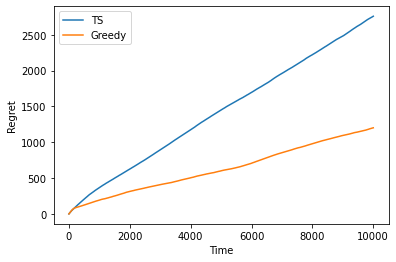

--- 59.31836700439453 seconds ---


In [16]:
plt.figure()
start_time = time.time()
for algo in algorithms:
    print('Start evaluation', algo.__class__.__name__)
    
    ev = EvaluationMortalMAB(envs, algo, horizon)
    
    mean_regret = ev.mean_regret()
    std_regret = ev.std_regret() 
    print('Regret of', algo.__class__.__name__, ':', mean_regret[-1], '+-', std_regret[-1], '\n')
    
    plt.plot(np.arange(horizon), mean_regret)
    #plt.fill_between(np.arange(nb_episodes * horizon), mean_regret-std_regret, mean_regret+std_regret, alpha=.2)
    plt.xlabel('Time')
    plt.ylabel('Regret')

plt.legend([algo.__class__.__name__ for algo in algorithms], loc=0)
plt.show()
print("--- %s seconds ---" % (time.time() - start_time))